In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns

sns.set()

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 乱数の種を固定（再現性を確保）
np.random.seed(1)

# シミュレーションするデータの長さを指定
sim_size = 100

# 正規分布に従う乱数を生成し、その累積和を取る
# → 各時点の値が「前の時点の値＋ランダム誤差」で決まるランダムウォーク過程を作成
mu_cumsum = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size))

# 結果として mu_cumsum は、次の式で表される：
# μ_t = μ_{t-1} + ε_t,   ε_t ~ N(0, 1)

In [4]:
# 乱数の種を固定（再現性の確保）
np.random.seed(1)

# シミュレーションするデータ数
sim_size = 100

# ランダムウォーク系列を格納する配列を初期化
mu_for = np.zeros(sim_size)

# 初期値（t = 0）を標準正規分布から生成
mu_for[0] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# 各時点 t における値を再帰的に生成
# y_t = y_{t-1} + ε_t  （ε_t ~ N(0, 1)）
for t in range(1, sim_size):
    mu_for[t] = mu_for[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

In [5]:
# 結果の比較：2通りの生成方法で同一のランダムウォークを作成できたか確認
all(mu_cumsum == mu_for)

True

In [6]:
# --------------------------------------------
# 乱数の種設定（再現性の確保）
# --------------------------------------------
np.random.seed(1)

# --------------------------------------------
# シミュレーション設定
# --------------------------------------------
# 観測数（サンプルサイズ）
sim_size = 100

# --------------------------------------------
# ドリフト成分（Δ_t）の初期化
# --------------------------------------------
# Δ_t ~ N(0, 1) と仮定するランダムウォーク的ドリフト
# 初期値 Δ_0 = 0 とし、1期目のみ乱数を代入
delta = np.zeros(sim_size)
delta[1] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# --------------------------------------------
# 水準成分（μ_t）の初期化
# --------------------------------------------
# μ_t = μ_{t-1} + Δ_t + ε_t の形を後で構築するため、
# ここでは μ_t の格納配列をゼロで初期化
mu_smooth = np.zeros(sim_size)

In [7]:
# --------------------------------------------
# ローカル線形トレンドモデルのシミュレーション
# --------------------------------------------
# モデル構造：
#   y_t = μ_t + ε_t
#   μ_t = μ_{t-1} + δ_{t-1}
#   δ_t = δ_{t-1} + η_t
#   ε_t ~ N(0, σ_ε²), η_t ~ N(0, σ_η²)
# --------------------------------------------

for t in range(2, sim_size):
    # ドリフト（傾き）成分の更新： δ_t = δ_{t-1} + η_t
    delta[t] = delta[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

    # 水準（レベル）成分の更新： μ_t = μ_{t-1} + δ_{t-1}
    mu_smooth[t] = mu_smooth[t - 1] + delta[t - 1]

# --------------------------------------------
# 観測値の生成： y_t = μ_t + ε_t
# --------------------------------------------
# 観測ノイズの分散 σ_ε² = 15² として、観測系列 y_t を生成
y_smooth = mu_smooth + stats.norm.rvs(loc=0, scale=15, size=sim_size)

In [8]:
# --------------------------------------------
# シミュレーション結果を DataFrame にまとめる
# --------------------------------------------
#   - delta: トレンドの傾き（slope） δ_t
#   - mu:    水準（level） μ_t
#   - y:     観測値（observation） y_t = μ_t + ε_t
#   - index: 日付（月次データとして2000年1月から）
# --------------------------------------------

smooth_df = pd.DataFrame(
    {"delta": delta, "mu": mu_smooth, "y": y_smooth},
    index=pd.date_range(start="2000-01-01", periods=sim_size, freq="MS"),
)

# 結果の確認（先頭3行）
print(smooth_df.head(3))

               delta        mu          y
2000-01-01  0.000000  0.000000  10.470481
2000-02-01  1.624345  0.000000  -6.706928
2000-03-01  1.012589  1.624345  19.991961


<Axes: >

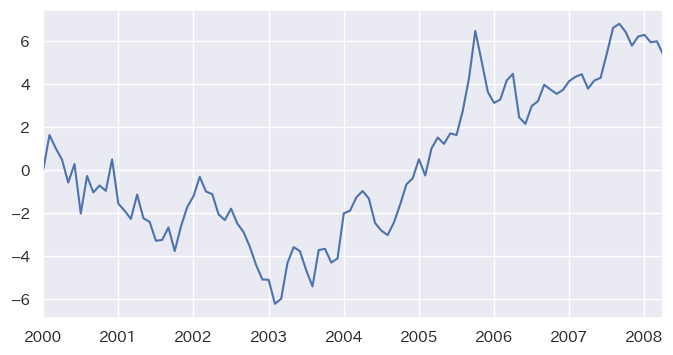

In [9]:
# --------------------------------------------
# ドリフト成分（傾き δ_t）の可視化
# --------------------------------------------
# ここでは、局所線形トレンドモデルにおける
# 「傾き（トレンドの変化率）」を表す δ_t をプロットしている。
# δ_t は状態方程式：
#   δ_t = δ_{t-1} + η_t,    η_t ~ N(0, σ_η²)
# に従うため、ゆるやかに変動するトレンドの滑らかさを可視化できる。
# --------------------------------------------

smooth_df["delta"].plot()

<Axes: >

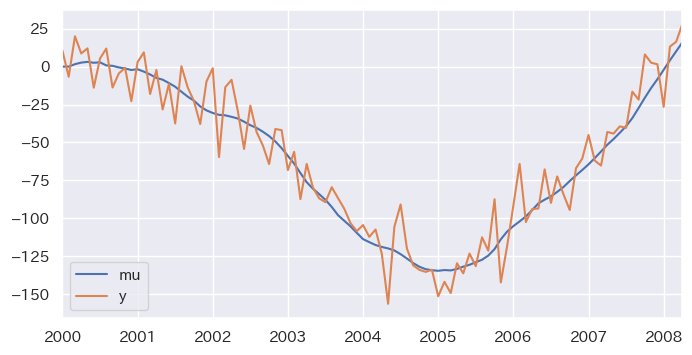

In [10]:
# --------------------------------------------
# 水準成分（μ_t）と観測値（y_t）の可視化
# --------------------------------------------
# μ_t は系列の「基調的な水準（trend level）」を表す潜在変数。
# 局所線形トレンドモデルにおける状態方程式：
#     μ_t = μ_{t-1} + δ_{t-1}
# により、ゆるやかに変化するトレンドを形成する。
#
# 一方、y_t は観測値であり、観測方程式：
#     y_t = μ_t + ε_t,   ε_t ~ N(0, σ_ε²)
# に従って、μ_t の周りにノイズとして分布する。
#
# このグラフでは、観測値 y_t（青線）と真の水準成分 μ_t（オレンジ線）
# を重ねて描画することで、観測ノイズによる揺らぎと
# 真のトレンドの滑らかさを対比的に確認できる。
# --------------------------------------------

smooth_df[["mu", "y"]].plot()

In [11]:
# --------------------------------------------------------
# 水準成分 μ_t は「正規ホワイトノイズの2階累積和」として表せる
# --------------------------------------------------------
# 局所線形トレンドモデル（Local Linear Trend Model）では：
#
#     μ_t = μ_{t-1} + δ_{t-1}
#     δ_t = δ_{t-1} + η_t,   η_t ~ N(0, σ_η²)
#
# したがって、δ_t はホワイトノイズ η_t の累積和、
# μ_t はそのさらに累積和、すなわち「2階累積和」となる。
#
# 言い換えれば、μ_t は「2階の積分過程」に相当し、
# 差分を2回とると定常系列になる（＝2階差分過程）。
#
# このことが、「局所線形トレンドモデルは 2階差分に由来する」
# といわれる理由である。
# --------------------------------------------------------

np.random.seed(1)
cumsum2 = np.cumsum(np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size)))

all(cumsum2[0:98] == mu_smooth[2:])

True

In [12]:
# ============================================================
# 📘 平滑化トレンドモデル（Local Linear Trend Model）
# ============================================================
# モデル仕様：
#   level='smooth trend' とすることで、以下の状態空間モデルを指定する。
#
#   観測方程式：
#       y_t = μ_t + ε_t,      ε_t ~ N(0, σ_ε²)
#
#   状態方程式（2階差分構造）：
#       μ_t = μ_{t-1} + δ_{t-1}
#       δ_t = δ_{t-1} + η_t,  η_t ~ N(0, σ_η²)
#
#   → μ_t は正規ホワイトノイズの2階累積和に相当（ARIMA(0,2,0) と等価）
#
# ============================================================
# 推定方法：
#   - statsmodels.tsa.UnobservedComponents を用いる。
#   - level='smooth trend' は「局所線形トレンドモデル」を意味する。
#   - method='nm' は Nelder-Mead 法による最尤推定を行う。
#   - maxiter=2000 は収束計算の繰り返し上限回数を指定。
# ============================================================

mod_smooth = tsa.UnobservedComponents(
    smooth_df["y"],  # 観測データ（シミュレーションされた系列）
    level="smooth trend",  # モデルの種類（平滑化トレンド）
)

# 最尤法によるパラメータの推定
res_smooth = mod_smooth.fit(
    method="nm", maxiter=2000  # Nelder-Mead法を使う  # 最大繰り返し数
)

Optimization terminated successfully.
         Current function value: 4.165624
         Iterations: 52
         Function evaluations: 103


In [13]:
# ============================================================
# 📘 推定された分散パラメータの平方根（標準偏差）
# ============================================================
# res_smooth.params には最尤推定された分散パラメータ（σ²）が格納されている。
#   1. σ_ε² : 観測誤差（Irregular）の分散
#   2. σ_η² : 過程誤差（Trend）の分散
#
# これらを平方根に変換することで、実際の標準偏差（σ）を求める：
#   √σ² = σ
#
# 例：
#   [σ_ε, σ_η] = np.sqrt(res_smooth.params)
#
# → モデル内部の不確実性（ノイズの大きさ）を直感的に理解できる。
# ============================================================

np.sqrt(res_smooth.params)

sigma2.irregular    14.138599
sigma2.trend         0.719196
dtype: float64

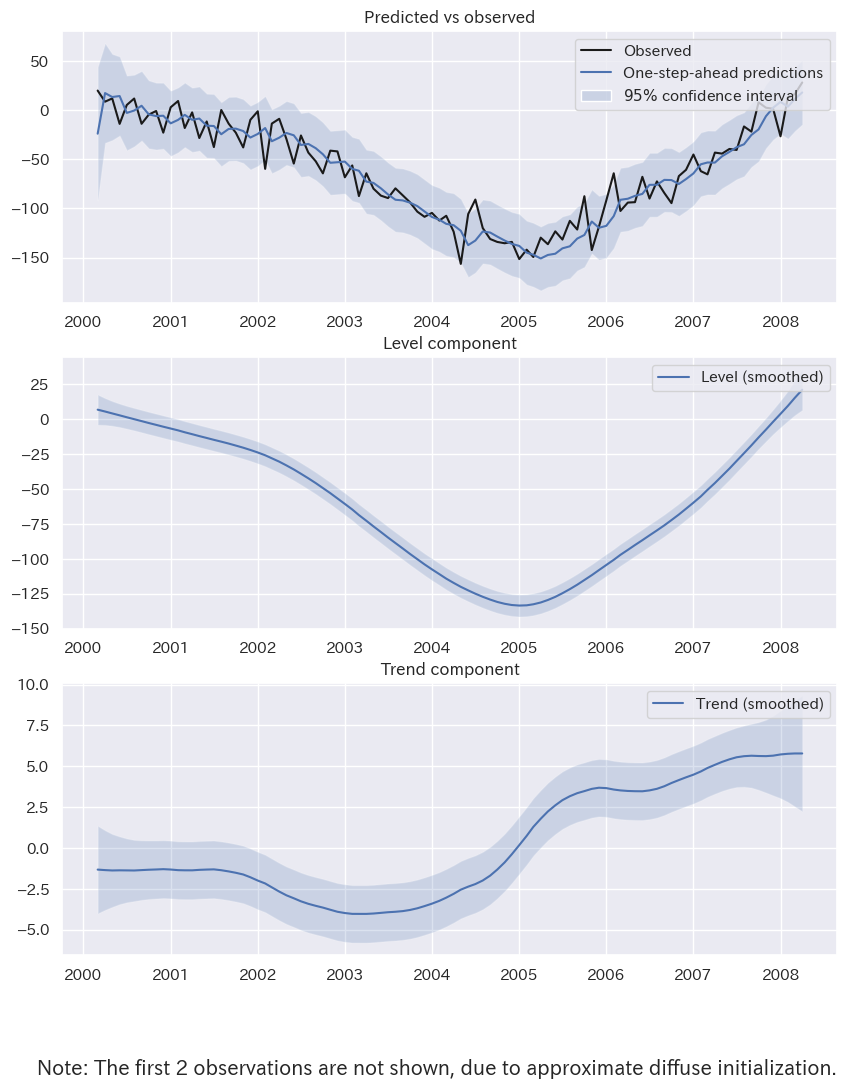

In [14]:
# ============================================================
# 📘 状態空間モデルの可視化：平滑化トレンドモデル
# ============================================================
# res_smooth.plot_components() は、推定された各成分（状態・トレンドなど）を可視化する。
#
# 【出力される主なプロット】
# 1️⃣ 観測系列 (Observed)：
#     実際の観測値 y_t（ノイズを含む系列）
#
# 2️⃣ Level（状態成分 α_t）：
#     トレンドの「水準」を表す。滑らかな時系列変化を捉える。
#
# 3️⃣ Trend（トレンド成分 Δα_t）：
#     水準の変化速度（勾配）を示す。増加・減少の傾向を反映。
#
# 【ポイント】
# - 「平滑化トレンドモデル (Smooth Trend Model)」は次のような構造：
#       y_t = μ_t + ε_t,       ε_t ~ N(0, σ_ε²)
#       μ_t = μ_{t-1} + δ_{t-1} + η_t,  η_t ~ N(0, σ_η²)
#       δ_t = δ_{t-1} + ζ_t,           ζ_t ~ N(0, σ_ζ²)
#
# - つまり、状態 μ_t（トレンド水準）と δ_t（トレンド勾配）が
#   ともにランダムウォークする「ランダムトレンドモデル」に近い。
#
# - プロットでは、推定された μ_t（レベル）と δ_t（トレンド）の
#   時間変化を視覚的に確認できる。
# ============================================================

fig = res_smooth.plot_components(figsize=(10, 12))

Text(0, 0.5, 'ドリフト（傾き）')

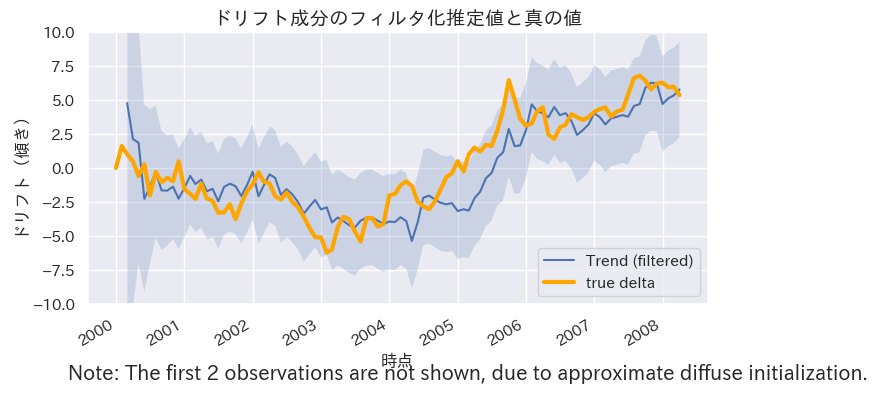

In [15]:
# ============================================================
# 🎯 ドリフト成分（傾き）のフィルタ化推定値の可視化
# ============================================================
# res_smooth.plot_components() を用いて、状態空間モデルから
# 推定された「ドリフト（trend）成分」のフィルタ化推定値を描画。
# さらに、シミュレーションで生成した真のドリフト値を重ねることで、
# モデルの推定性能を視覚的に検証する。
# ------------------------------------------------------------
# 【理論的背景】
# 平滑化トレンドモデル（Smooth Trend Model）は次のように表される：
#
# $$
# \begin{aligned}
# y_t &= \mu_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
# \mu_t &= \mu_{t-1} + \delta_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_\eta^2) \\
# \delta_t &= \delta_{t-1} + \zeta_t, \quad \zeta_t \sim N(0, \sigma_\zeta^2)
# \end{aligned}
# $$
#
# - $\mu_t$: トレンドの水準（Level）
# - $\delta_t$: トレンドの傾き（Drift）
# - $\varepsilon_t, \eta_t, \zeta_t$: 各ノイズ項
#
# フィルタ化推定値（Filtered Estimate）は、時点 $t$ までの情報を用いて
# 推定した $\delta_t$ の期待値である。
# ============================================================

fig = res_smooth.plot_components(
    which="filtered",  # フィルタ化推定値を描画
    observed=False,  # 観測値は非表示
    level=False,  # 水準成分は非表示
    trend=True,  # ドリフト成分のみ表示
    seasonal=False,  # 季節成分は非表示
    figsize=(8, 4),  # 図のサイズ
)

# ------------------------------------------------------------
# ✅ 真のドリフト成分（シミュレーションで生成した delta）を重ね描画
# ------------------------------------------------------------
smooth_df.delta.plot(linewidth=3, label="true delta", color="orange")

# 凡例
plt.legend()

# Y軸範囲の調整（-10〜10）
plt.ylim(-10, 10)
plt.title("ドリフト成分のフィルタ化推定値と真の値", fontsize=14)
plt.xlabel("時点", fontsize=12)
plt.ylabel("ドリフト（傾き）", fontsize=12)

In [16]:
# ============================================================
# 🎯 ドリフト成分（trend）のフィルタ化・平滑化推定値の取得
# ============================================================
# 状態空間モデル（平滑化トレンドモデル）から、
# トレンドの傾き（ドリフト成分）に関する推定値を取り出す。
#
# res_smooth.trend['filtered'] : カルマンフィルタによる逐次推定結果
# res_smooth.trend['smoothed'] : カルマンスムーザによる事後推定結果
# ------------------------------------------------------------
# 【理論的背景】
# フィルタ化推定値：
#   $$ E[\delta_t | y_1, ..., y_t] $$
#   ┗ 時点 t までの情報を使って算出（リアルタイム予測）
#
# 平滑化推定値：
#   $$ E[\delta_t | y_1, ..., y_T] $$
#   ┗ サンプル全体（T時点までの観測）を使って後から修正した推定値
#
# 一般に、平滑化推定値の方が真値に近いとされる。
# ============================================================

# フィルタ化推定量（時点 t までの情報でのドリフト推定）
print("📘 フィルタ化推定量（Filtered Estimate）:")
print(res_smooth.trend["filtered"][:4])

# 平滑化推定量（全時点の情報を使って後から補正された推定値）
print("\n📗 平滑化推定量（Smoothed Estimate）:")
print(res_smooth.trend["smoothed"][:4])

📘 フィルタ化推定量（Filtered Estimate）:
[  0.         -17.16845309   4.77003853   2.13530599]

📗 平滑化推定量（Smoothed Estimate）:
[-1.29717419 -1.29385304 -1.32497374 -1.35586851]


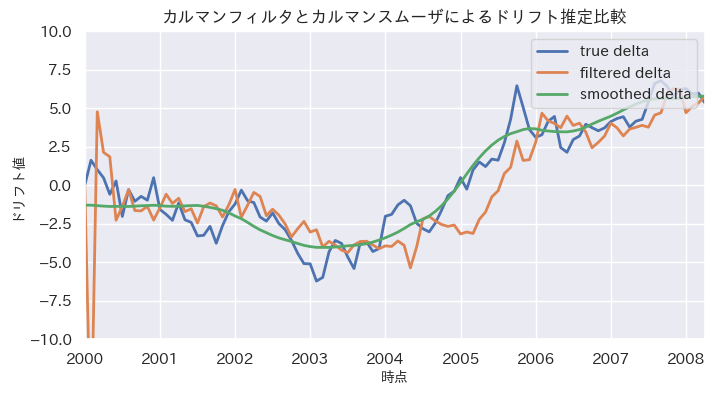

In [17]:
# ============================================================
# 🎯 ドリフト成分（trend）の真値・フィルタ化・平滑化の比較可視化
# ============================================================
# カルマンフィルタとカルマンスムーザによる推定精度を比較。
#   - True delta：シミュレーションで生成した真のドリフト成分
#   - Filtered delta：観測時点までの情報で推定した逐次推定値
#   - Smoothed delta：全時点の情報を用いて補正した事後推定値
# ------------------------------------------------------------
# 期待される結果：
#   ・平滑化推定値（smoothed）は真値（true delta）に最も近くなる
#   ・フィルタ化推定値（filtered）は滑らかだが若干遅れる
# ============================================================

# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "true delta": smooth_df.delta,
        "filtered delta": res_smooth.trend["filtered"],
        "smoothed delta": res_smooth.trend["smoothed"],
    }
)

# 可視化
plot_df.plot(figsize=(8, 4), linewidth=2)
plt.title("カルマンフィルタとカルマンスムーザによるドリフト推定比較", fontsize=12)
plt.xlabel("時点", fontsize=10)
plt.ylabel("ドリフト値", fontsize=10)
plt.ylim(-10, 10)
plt.legend(loc="upper right")

# ✅ GitHubレビューコメント
# この図は、状態空間モデルのトレンド成分（ドリフト）の推定過程を可視化している。
# 平滑化推定（Smoothed）は過去・未来の情報を用いるため真値により近く、
# フィルタ化推定（Filtered）は観測時点までの情報で更新されるため若干遅れる。
# これにより、カルマンフィルタとカルマンスムーザの役割の違いが直感的に理解できる。

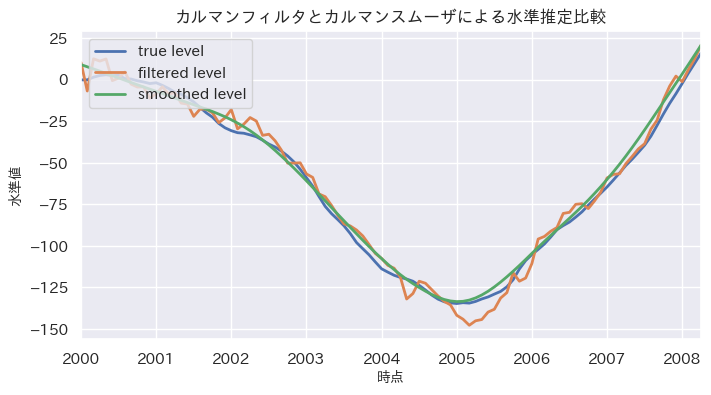

In [18]:
# ============================================================
# 🎯 水準成分（level）の真値・フィルタ化・平滑化の比較可視化
# ============================================================
# カルマンフィルタとカルマンスムーザによる「水準」の推定精度を比較。
#   - True level：シミュレーションで生成した真の水準成分
#   - Filtered level：観測時点までの情報で更新された逐次推定値
#   - Smoothed level：全時点の情報を用いて補正された事後推定値
# ------------------------------------------------------------
# 期待される結果：
#   ・平滑化推定値（smoothed）は真値（true level）に最も近くなる
#   ・フィルタ化推定値（filtered）は若干遅れが見られる
# ============================================================

# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "true level": smooth_df.mu,
        "filtered level": res_smooth.level["filtered"],
        "smoothed level": res_smooth.level["smoothed"],
    }
)

# 可視化
plot_df.plot(figsize=(8, 4), linewidth=2)
plt.title("カルマンフィルタとカルマンスムーザによる水準推定比較", fontsize=12)
plt.xlabel("時点", fontsize=10)
plt.ylabel("水準値", fontsize=10)
plt.legend(loc="upper left")

# ✅ GitHubレビューコメント
# この図は、状態空間モデルにおける水準（level）推定の精度を比較している。
# フィルタ化推定（Filtered）は逐次更新によるリアルタイム推定、
# 平滑化推定（Smoothed）は全情報を使った最終的な補正推定であり、
# 後者が真値に最も近づくことが確認できる。

In [19]:
# ============================================================
# 🎯 ランダムウォークドリフト成分（Local Linear Trend Model の前段準備）
# ============================================================
# 状態空間モデルの「ローカル線形トレンドモデル（local linear trend）」の基礎を作る。
#   - ドリフト成分（delta_t）: トレンドの変化率。ランダムウォーク過程に従う。
#   - 水準成分（mu_t）: 系列の平均的水準。ドリフト成分を累積して決まる。
# ------------------------------------------------------------
# 数式表現：
#   δ_t = δ_{t-1} + η_t,     η_t ~ N(0, σ_η²)
#   μ_t = μ_{t-1} + δ_{t-1}
# ============================================================

# 乱数の種を固定（再現性の確保）
np.random.seed(1)

# シミュレーションする時系列の長さ
sim_size = 100

# ------------------------------------------------------------
# ドリフト成分 δ_t（トレンドの傾きの変動）
# ------------------------------------------------------------
# 初期値はゼロに設定
delta = np.zeros(sim_size)

# 1期目のドリフト成分のみランダムに与える（平均0, 分散1 の正規分布）
delta[1] = stats.norm.rvs(loc=0, scale=1, size=1)[0]

# ------------------------------------------------------------
# 水準成分 μ_t（系列の平均的水準）
# ------------------------------------------------------------
# 初期値はゼロ（系列が0から始まると仮定）
mu_trend = np.zeros(sim_size)

# ✅ GitHubレビューコメント
# このセルでは、トレンドを構成する「傾き（delta_t）」と「水準（mu_t）」の
# 基本的な状態ベクトルを初期化している。
# 次のステップで、これらを再帰的に更新し、ローカル線形トレンド系列を生成する。

In [20]:
# ============================================================
# 🎯 ローカル線形トレンドモデル（Local Linear Trend Model）のシミュレーション
# ============================================================
# 状態方程式：
#   δ_t = δ_{t-1} + η_t,  η_t ~ N(0, σ_η²)
#   μ_t = μ_{t-1} + δ_t + ζ_t, ζ_t ~ N(0, σ_ζ²)
# 観測方程式：
#   y_t = μ_t + ε_t,  ε_t ~ N(0, σ_ε²)
# ------------------------------------------------------------
# ここでは：
#   ・η_t（トレンドの変動）に対応する分散 = 1
#   ・ζ_t（平滑化ノイズ）に対応する分散 = 10²
#   ・ε_t（観測ノイズ）に対応する分散 = 15²
# として、100期間のデータを生成する。
# ============================================================

# シミュレーション実行
for t in range(2, sim_size):
    # ドリフト成分 δ_t の更新（ランダムウォーク）
    delta[t] = delta[t - 1] + stats.norm.rvs(loc=0, scale=1, size=1)[0]

    # 水準成分 μ_t の更新（前期の水準 + 現在のトレンド + 平滑化ノイズ）
    mu_trend[t] = (
        mu_trend[t - 1]
        + delta[t]  # 現在の傾き（トレンド）を反映
        + stats.norm.rvs(loc=0, scale=10, size=1)[0]  # 平滑化ノイズ ζ_t
    )

# 観測方程式：観測値 y_t = μ_t + ε_t
y_trend = mu_trend + stats.norm.rvs(loc=0, scale=15, size=sim_size)

# ✅ GitHubレビューコメント
# - ドリフト成分（delta）はトレンドの傾きを示し、滑らかに変化する。
# - 水準成分（mu_trend）はその累積であり、全体的なトレンドを形成する。
# - 最後に観測ノイズ（ε_t）を加えることで観測データ y_t が得られる。
# これにより、現実的な非定常系列（トレンド＋ノイズ）を再現できる。

In [21]:
# ============================================================
# 📊 データの統合と確認
# ============================================================
# 生成したドリフト成分(delta)、水準成分(mu_trend)、観測値(y_trend)
# をひとまとめにして、時系列DataFrameとして格納する。
# インデックスには2000年1月から月次(MS)で100期間の連続した日付を設定する。
# ============================================================

trend_df = pd.DataFrame(
    {
        "delta": delta,  # ドリフト成分：トレンドの傾き
        "mu": mu_trend,  # 水準成分：系列の基準水準
        "y": y_trend,  # 観測値：水準＋ノイズ
    },
    index=pd.date_range(start="2000-01-01", periods=sim_size, freq="MS"),
)

# ============================================================
# 結果の確認
# 先頭3行を出力して、生成された系列の構造を確認する。
# ============================================================

print(trend_df.head(3))

               delta        mu          y
2000-01-01  0.000000  0.000000   6.304233
2000-02-01  1.624345  0.000000  12.164275
2000-03-01  1.012589 -4.269129  11.397503


<Axes: title={'center': '水準成分と観測値の比較'}, xlabel='年月', ylabel='値'>

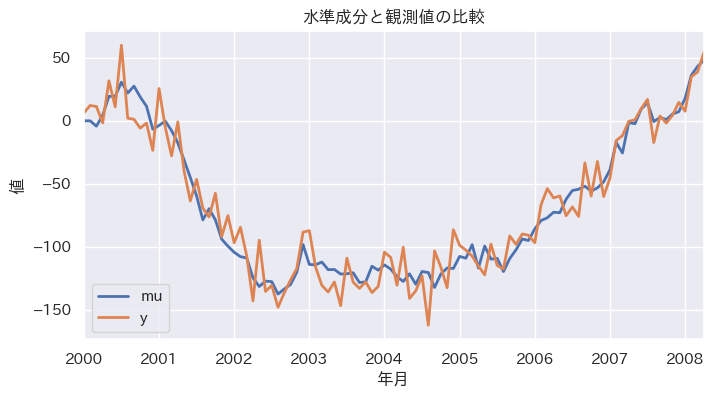

In [22]:
# ============================================================
# 📈 水準成分と観測値の可視化
# ============================================================
# 「mu」：真の水準成分（トレンド）
# 「y」 ：観測値（ノイズを含む実際の観測系列）
# ============================================================
# これにより、観測値がトレンド周りにどの程度ばらついているか、
# モデルがどのようなノイズ構造を前提としているかを視覚的に確認できる。
# ============================================================

trend_df[["mu", "y"]].plot(
    figsize=(8, 4),
    title="水準成分と観測値の比較",
    xlabel="年月",
    ylabel="値",
    linewidth=2,
)

# 💡 GitHubレビュー用コメント：
# グラフは「観測値 y_t」が真のトレンド μ_t の周囲を振動する様子を示す。
# この構造は、後に適用する「平滑化トレンドモデル（Local Linear Trend Model）」の前提に一致し、
# トレンド変化を含む非定常系列におけるモデル化の直感的理解を助ける。

In [23]:
# ============================================================
# ⚙️ ローカル線形トレンドモデル（Local Linear Trend Model）
# ============================================================
# モデルの定義：
#   観測方程式:  y_t = μ_t + ε_t, ε_t ~ N(0, σ_ε²)
#   状態方程式:
#       μ_t = μ_{t-1} + δ_{t-1} + η_t, η_t ~ N(0, σ_η²)
#       δ_t = δ_{t-1} + ζ_t, ζ_t ~ N(0, σ_ζ²)
#
# ・μ_t：水準成分（level）
# ・δ_t：トレンド（ドリフト）成分
# ・ε_t, η_t, ζ_t：それぞれ観測・レベル・トレンドのノイズ
# ============================================================

# モデルの構築
mod_trend = tsa.UnobservedComponents(
    trend_df["y"],  # 対象データ
    level="local linear trend",  # モデルを「ローカル線形トレンド」と指定
)

# ------------------------------------------------------------
# 最尤法によるパラメータ推定
# ------------------------------------------------------------
# ・method='nm'：Nelder–Mead法による最適化
# ・maxiter=2000：反復回数の上限
# ------------------------------------------------------------
res_trend = mod_trend.fit(method="nm", maxiter=2000)

# 💡 GitHubレビュー用コメント：
# このモデルは「ローカルレベルモデル」の拡張であり、
# 水準 μ_t の変化に加えて傾き δ_t の変化も確率的に扱う。
# そのため、トレンドの加速度や滑らかな変化を自然に表現できる。
# 特に景気変動や季節調整済み系列など、なめらかな構造をもつ実データに有効である。

Optimization terminated successfully.
         Current function value: 4.332766
         Iterations: 129
         Function evaluations: 239


In [24]:
# ============================================================
# 📊 推定結果の確認：分散パラメータの平方根（＝標準偏差）
# ============================================================
# ローカル線形トレンドモデルでは、
# 以下の3つの分散パラメータが推定される：
#
# 1. σ_ε² ：観測誤差の分散（Irregular variance）
# 2. σ_η² ：レベル変動の分散（Level variance）
# 3. σ_ζ² ：トレンド変動の分散（Trend variance）
#
# ここでは、それぞれの分散の平方根（標準偏差）を表示する。
# ============================================================

np.sqrt(res_trend.params)

# 💡 GitHubレビュー用コメント：
# 分散の平方根を確認することで、各成分（観測・レベル・トレンド）の
# ノイズ強度を比較できる。特に σ_ζ が小さい場合、
# トレンドはほぼ直線（滑らか）に近くなる。
# 一方、σ_ζ が大きい場合、トレンドが急に変化しやすくなる。

sigma2.irregular    14.860495
sigma2.level         7.109954
sigma2.trend         0.731254
dtype: float64

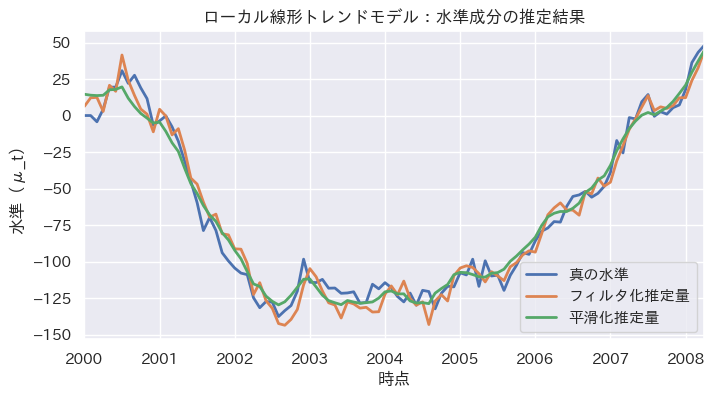

In [25]:
# ============================================================
# 📈 フィルタ化推定量・平滑化推定量の比較可視化
# ============================================================

# DataFrameにまとめる
# ・true level         ：真の水準（シミュレーションで生成したμ_t）
# ・filtered level     ：カルマンフィルタによる逐次推定値（a_t|t）
# ・smoothed level     ：全データを用いた平滑化推定値（a_t|T）
plot_df = pd.DataFrame(
    {
        "true level": trend_df.mu,
        "filtered level": res_trend.level["filtered"],
        "smoothed level": res_trend.level["smoothed"],
    }
)

# 可視化
plot_df.plot(figsize=(8, 4), linewidth=2)

# 軸ラベルとタイトル
plt.title("ローカル線形トレンドモデル：水準成分の推定結果")
plt.xlabel("時点")
plt.ylabel("水準（μ_t）")

# 凡例
plt.legend(["真の水準", "フィルタ化推定量", "平滑化推定量"])

# 💡 GitHubレビュー用コメント：
# ・フィルタ化推定量（filtered）は観測データの逐次的な更新結果。
# ・平滑化推定量（smoothed）は全データを用いて再評価された推定結果で、
#   より滑らかで真の値（true level）に近い形状となる。
# ・ローカル線形トレンドモデルでは、状態空間の2階構造により
#   トレンド変動も同時に推定される点が特徴である。

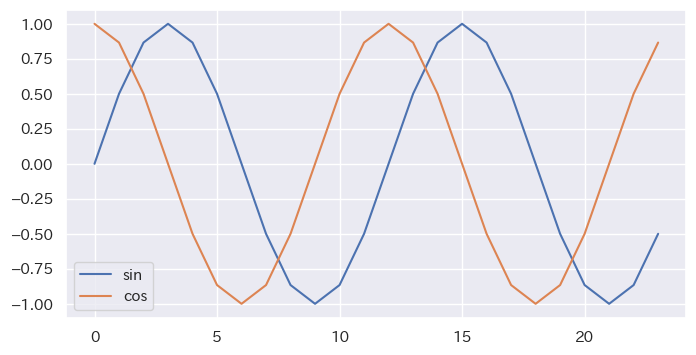

In [26]:
# ===============================================
# 🔁 単純な三角関数（周期性のある波の例）
# ===============================================

m = 12  # 周期（例：1年を12か月とした季節性を想定）
sin = np.zeros(24)  # sin波（正弦波）
cos = np.zeros(24)  # cos波（余弦波）

# λ（波の角周波数）= 2π / m
lambda_1 = 2 * np.pi * 1 / m

# 各時点 t に対して sin, cos の値を計算
for t in range(0, 24):
    sin[t] = np.sin(lambda_1 * t)
    cos[t] = np.cos(lambda_1 * t)

# 折れ線グラフを描画
plt.plot(sin, label="sin")  # 正弦波
plt.plot(cos, label="cos")  # 余弦波
plt.legend()

# -----------------------------------------------
# 💡 GitHubレビュー用コメント
# ・sin波・cos波は時系列における「季節成分」を表現する基底関数。
# ・周期 m=12 は「年周期」を想定しており、
#   ARIMAや状態空間モデルの季節成分はこれらの波で近似される。
# ・λ = 2π/m は1周期の角周波数で、t の進行に応じて波が1周する。
# ・このペア（sin, cos）を用いて任意の位相の周期変動を再現できる。

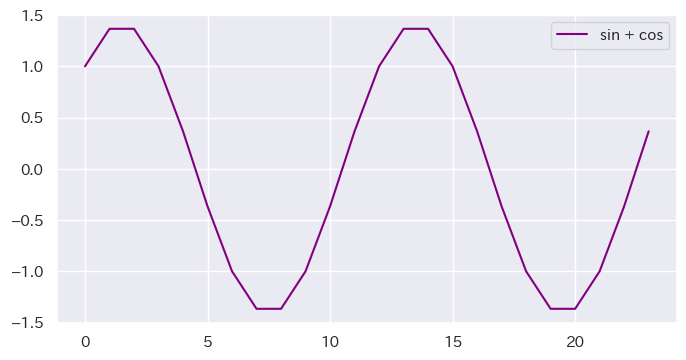

In [27]:
# ===============================================
# 🔁 sin波とcos波の和（合成波の例）
# ===============================================

# sin波とcos波を足し合わせた合成波を作成
gamma = np.zeros(24)

for t in range(0, 24):
    gamma[t] = np.sin(lambda_1 * t) + np.cos(lambda_1 * t)

# 折れ線グラフを描画
plt.plot(gamma, label="sin + cos", color="purple")
plt.legend()

# -----------------------------------------------
# 💡 GitHubレビュー用コメント
# ・sin波とcos波の線形結合も、同じ周期 m=12 の波形を持つ。
# ・実際には以下のように位相を持つ単一のsin波にまとめられる：
#   $$\sin(\lambda t) + \cos(\lambda t)
#     = \sqrt{2} \sin(\lambda t + \pi/4)$$
# ・このように、sin・cosの重みを変化させることで
#   「振幅（amplitude）」や「位相（phase）」を自由に制御できる。
# ・状態空間モデルやSARIMAモデルの季節成分は
#   こうした三角関数基底の合成で表現される。

In [28]:
# ======================================================
# 🔁 再帰的に求めた sin波＋cos波 の生成
# ======================================================

gamma_1 = np.zeros(24)
gamma_1_star = np.zeros(24)

# 初期値（t=0 のときの値）
gamma_1[0] = 1
gamma_1_star[0] = 1

# 再帰式による更新（周期成分の再帰的生成）
for t in range(1, 24):
    gamma_1[t] = gamma_1[t - 1] * np.cos(lambda_1) + gamma_1_star[t - 1] * np.sin(
        lambda_1
    )
    gamma_1_star[t] = -gamma_1[t - 1] * np.sin(lambda_1) + gamma_1_star[t - 1] * np.cos(
        lambda_1
    )

# 元の sin(t) + cos(t) の結果と一致するか確認
np.sum((gamma - gamma_1) ** 2)

# -----------------------------------------------
# 💡 GitHubレビュー用コメント
# ・この再帰式は「状態空間表現による周期成分」の基本形である。
# ・以下のような行列表現でも書ける：
#   $$
#   \begin{pmatrix}
#   \gamma_t \\ \gamma_t^*
#   \end{pmatrix}
#   =
#   \begin{pmatrix}
#   \cos\lambda & \sin\lambda \\
#   -\sin\lambda & \cos\lambda
#   \end{pmatrix}
#   \begin{pmatrix}
#   \gamma_{t-1} \\ \gamma_{t-1}^*
#   \end{pmatrix}
#   $$
# ・この式は回転行列（rotation matrix）に相当し、
#   周期 $\frac{2\pi}{\lambda}$ の三角関数を再帰的に生成できる。
# ・状態空間モデルの季節成分（季節変動）は、この形を直接利用して表現される。

2.523430450333932e-29

In [29]:
# ======================================================
# 🎵 sin波・cos波の重み付き線形結合
# ======================================================

gamma_1_weight = np.zeros(24)

# 重み付きの三角関数を合成（周期性を保ちつつ位相を変化させる）
for t in range(0, 24):
    gamma_1_weight[t] = -1 * np.sin(lambda_1 * t) + 1 * np.cos(lambda_1 * t)

# -----------------------------------------------
# 💡 GitHubレビュー用コメント
# ・この式は「sin波」と「cos波」の線形結合：
#   $$
#   \gamma_t = a \cos(\lambda t) + b \sin(\lambda t)
#   $$
#   の形をしており、一般に任意の周期関数を位相シフトつきで表現できる。
#
# ・ここでは $a=1$, $b=-1$ なので、振幅 $\sqrt{a^2 + b^2} = \sqrt{2}$、
#   位相 $\phi = \tan^{-1}(b/a) = -\pi/4$ の波になる。
#
# ・したがって、この波形は：
#   $$
#   \gamma_t = \sqrt{2}\cos(\lambda t + \pi/4)
#   $$
#   と等価であり、同じ周期 $\frac{2\pi}{\lambda_1}$ を持つが、
#   cos波を $\pi/4$ だけ先にシフトした形になる。
#
# ・状態空間モデルでは、このような「sin・cosの線形結合」を
#   季節要素（Fourier型季節成分）の表現に利用している。

In [30]:
# ======================================================
# 🎵 6か月周期（半期周期）の三角関数
# ======================================================

lambda_2 = 2 * np.pi * 2 / m  # 周期12のうち2倍の周波数 → 6か月周期成分
gamma_2 = np.zeros(24)

for t in range(0, 24):
    gamma_2[t] = np.sin(lambda_2 * t) + np.cos(lambda_2 * t)

# -----------------------------------------------
# 💡 GitHubレビュー用コメント
# ・この式は周期 $m=12$ のうち、倍周波数（2倍速）を持つ波を生成している。
#
# ・一般形は：
#   $$
#   \gamma_t = \sin\left(\frac{4\pi t}{m}\right)
#            + \cos\left(\frac{4\pi t}{m}\right)
#   $$
#   であり、1年周期の「半年周期（6か月）」の成分に対応する。
#
# ・これは、Fourier展開で季節成分を分解する際の
#   「第2調和成分（2nd harmonic）」に該当する。
#
# ・$k=1,2,...,m/2$ の各成分：
#   $$
#   \sin\left(\frac{2\pi k t}{m}\right), \quad
#   \cos\left(\frac{2\pi k t}{m}\right)
#   $$
#   を足し合わせることで、任意の周期的変動（季節性）を近似できる。

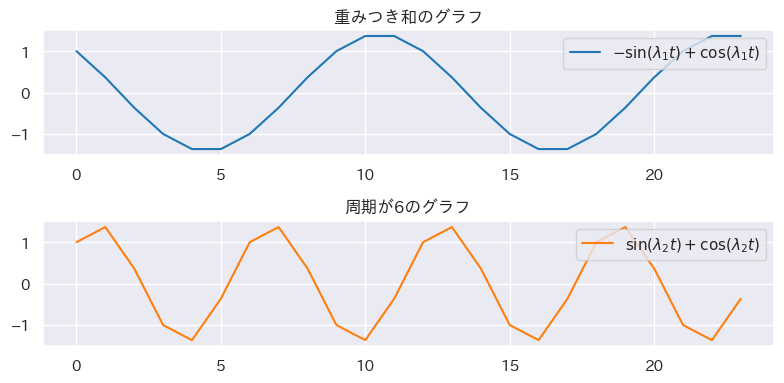

In [31]:
# ======================================================
# 🎨 三角関数（季節成分）の可視化
# ======================================================

fig, ax = plt.subplots(nrows=2, tight_layout=True, figsize=(8, 4))

# ------------------------------------------------------
# 🔹 上段：重みつき sin, cos の和
# ------------------------------------------------------
ax[0].set_title("重みつき和のグラフ", fontname="IPAexGothic")
ax[0].plot(
    gamma_1_weight, color="tab:blue", label=r"$-\sin(\lambda_1 t) + \cos(\lambda_1 t)$"
)
ax[0].legend()

# ------------------------------------------------------
# 🔹 下段：周期6の三角関数（半年周期成分）
# ------------------------------------------------------
ax[1].set_title("周期が6のグラフ", fontname="IPAexGothic")
ax[1].plot(
    gamma_2, color="tab:orange", label=r"$\sin(\lambda_2 t) + \cos(\lambda_2 t)$"
)
ax[1].legend()

# ------------------------------------------------------
# 💬 GitHubレビュー用コメント
# ------------------------------------------------------
# ・上段の「重みつき和」は、sin波とcos波の線形結合で位相シフトを伴う波を示す。
#   $$
#   \gamma_t = -\sin(\lambda_1 t) + \cos(\lambda_1 t)
#   $$
#   これは周期 m=12 の「第1調和成分」に対応する。
#
# ・下段の「周期6のグラフ」は、6か月周期の成分：
#   $$
#   \gamma_t = \sin(\lambda_2 t) + \cos(\lambda_2 t),
#   \quad \lambda_2 = \frac{4\pi}{m}
#   $$
#   であり、Fourier 展開における「第2調和成分」を可視化している。
#
# ・このように、複数の sin, cos 成分を組み合わせることで、
#   季節性を持つ時系列の波形を柔軟に表現できる。

In [32]:
# 乱数の種
np.random.seed(1)

# 季節成分
s = np.zeros(sim_size)

# 季節成分の初期値
s_12 = np.array([-30, -75, -45, -15, 5, 30, 40, 60, 25, 15, 5, -15])

In [33]:
# 1月の季節成分の再現
print("2月から12月の季節成分", s_12[1:12])

print("1月の季節成分の再現  ", 0 - np.sum(s_12[1:12]))

2月から12月の季節成分 [-75 -45 -15   5  30  40  60  25  15   5 -15]
1月の季節成分の再現   -30


In [34]:
# ======================================================
# 🎯 季節成分を含むローカルレベル＋トレンドモデルのシミュレーション
# ======================================================

# ------------------------------------------------------
# 🔹 1. 初期化
# ------------------------------------------------------
# 最初の12時点における季節成分（s_12）を初期値として設定
s[0:12] = s_12

# ------------------------------------------------------
# 🔹 2. 季節成分のシミュレーション
# ------------------------------------------------------
# 各時点での季節成分は「ランダムノイズ − 過去11期間の季節成分の和」で更新
for t in range(12, sim_size):
    s[t] = stats.norm.rvs(loc=0, scale=2, size=1)[0] - np.sum(s[(t - 11) : t])

# ------------------------------------------------------
# 🔹 3. 状態方程式
# ------------------------------------------------------
# ローカル線形トレンド（mu_trend）に季節成分（s）を加えて状態を生成
alpha = mu_trend + s

# ------------------------------------------------------
# 🔹 4. 観測方程式
# ------------------------------------------------------
# 状態に観測誤差（標準偏差15）を加えて観測値を生成
y_bsts = alpha + stats.norm.rvs(loc=0, scale=15, size=sim_size)

# ------------------------------------------------------
# ✅ コメント（GitHubレビュー用）
# ------------------------------------------------------
# 本シミュレーションは、状態空間モデルの一形態である
# 「ローカル線形トレンド＋季節成分モデル（BSTS型構造時系列）」を模倣している。
#
# 数式で表すと以下の通り：
#
# $$
# \begin{aligned}
# y_t &= \mu_t + s_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
# \mu_t &= \mu_{t-1} + \delta_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_\eta^2) \\
# \delta_t &= \delta_{t-1} + \zeta_t, \quad \zeta_t \sim N(0, \sigma_\zeta^2) \\
# s_t &= -\sum_{i=1}^{m-1} s_{t-i} + \omega_t, \quad \omega_t \sim N(0, \sigma_\omega^2)
# \end{aligned}
# $$
#
# ・$\mu_t$：ローカル線形トレンド（水準＋ドリフト）
# ・$s_t$：周期 $m=12$ の季節成分
# ・$\varepsilon_t$：観測誤差
#
# この構造は「状態空間モデルの構造分解表現（structural decomposition）」として
# カルマンフィルタにより推定可能である。

In [35]:
# DataFrameにまとめる
bsts_df = pd.DataFrame(
    {"delta": delta, "mu": mu_trend, "s": s, "alpha": alpha, "y": y_bsts},
    index=pd.date_range(start="2000-01-01", periods=sim_size, freq="MS"),
)

# 結果の確認
print(bsts_df.head(3))

               delta        mu     s      alpha          y
2000-01-01  0.000000  0.000000 -30.0 -30.000000 -28.172681
2000-02-01  1.624345  0.000000 -75.0 -75.000000 -58.057741
2000-03-01  1.012589 -4.269129 -45.0 -49.269129 -31.285360


<Axes: >

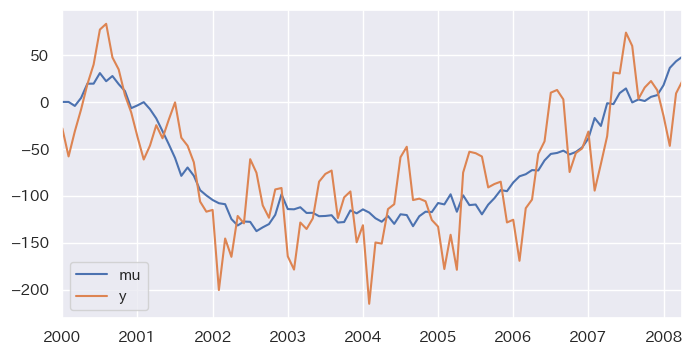

In [36]:
# 水準成分と観測値の可視化
bsts_df[["mu", "y"]].plot()

In [37]:
# ======================================================
# 🎯 季節変動ありのローカル線形トレンドモデル（BSTS型）
# ======================================================

# ------------------------------------------------------
# 🔹 1. モデルの定義
# ------------------------------------------------------
mod_bsts = tsa.UnobservedComponents(
    bsts_df["y"],  # 対象データ（観測系列）
    level="local linear trend",  # 水準＋ドリフトの2階ランダムウォーク構造
    seasonal=12,  # 季節成分（周期12：月次データを想定）
)

# ------------------------------------------------------
# 🔹 2. パラメータの推定（最尤法）
# ------------------------------------------------------
# Nelder-Mead法による最適化を実施し、分散パラメータを推定
res_bsts = mod_bsts.fit(
    method="nm", maxiter=2000  # Nelder-Mead法を使用  # 最大繰り返し回数を2000に設定
)

# ------------------------------------------------------
# ✅ コメント（GitHubレビュー用）
# ------------------------------------------------------
# 「季節変動ありのローカル線形トレンドモデル」は、
# 状態空間表現を持つ構造時系列モデル（Structural Time Series Model）の一種である。
#
# 数式表現は以下の通り：
#
# $$
# \begin{aligned}
# y_t &= \mu_t + s_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
# \mu_t &= \mu_{t-1} + \delta_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_\eta^2) \\
# \delta_t &= \delta_{t-1} + \zeta_t, \quad \zeta_t \sim N(0, \sigma_\zeta^2) \\
# s_t &= -\sum_{i=1}^{m-1} s_{t-i} + \omega_t, \quad \omega_t \sim N(0, \sigma_\omega^2)
# \end{aligned}
# $$
#
# ・$\mu_t$：水準（level）
# ・$\delta_t$：トレンド（drift）
# ・$s_t$：季節成分（周期 $m=12$）
# ・$\varepsilon_t$：観測誤差
#
# このモデルは、「BSTS（Bayesian Structural Time Series）」や
# 「ローカル線形トレンド＋季節成分モデル」として知られ、
# カルマンフィルタを用いることで非定常な構造変化を含む時系列の
# 平滑化・予測・分解が可能である。

Optimization terminated successfully.
         Current function value: 4.001858
         Iterations: 264
         Function evaluations: 465


In [38]:
# 参考：推定された分散の平方根
np.sqrt(res_bsts.params)

sigma2.irregular    15.708417
sigma2.level         7.388779
sigma2.trend         0.964630
sigma2.seasonal      0.000021
dtype: float64

<Axes: >

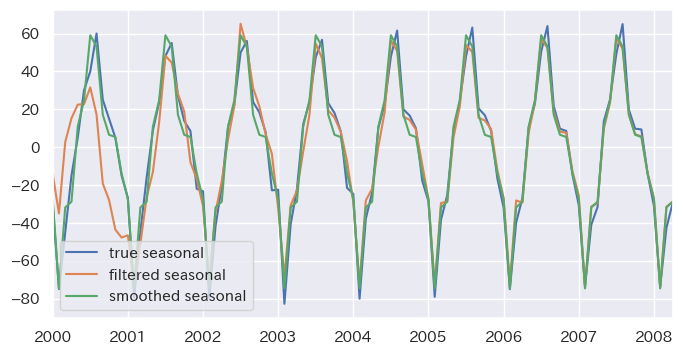

In [39]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "true seasonal": bsts_df["s"],
        "filtered seasonal": res_bsts.seasonal["filtered"],
        "smoothed seasonal": res_bsts.seasonal["smoothed"],
    }
)

# 可視化
plot_df.plot()

<Axes: >

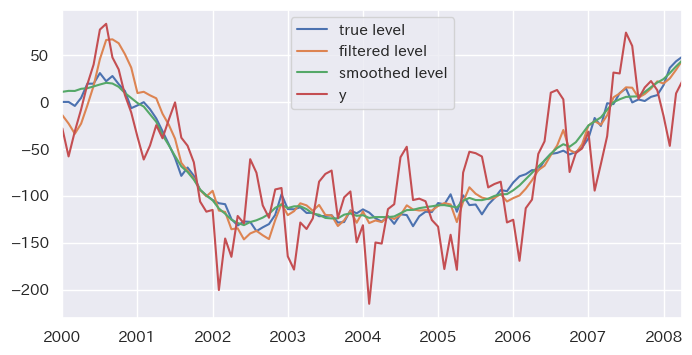

In [40]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "true level": bsts_df["mu"],
        "filtered level": res_bsts.level["filtered"],
        "smoothed level": res_bsts.level["smoothed"],
        "y": bsts_df["y"],
    }
)

# 可視化
plot_df.plot()

<Axes: title={'center': 'フィルタ化・平滑化推定量と真の状態の比較'}>

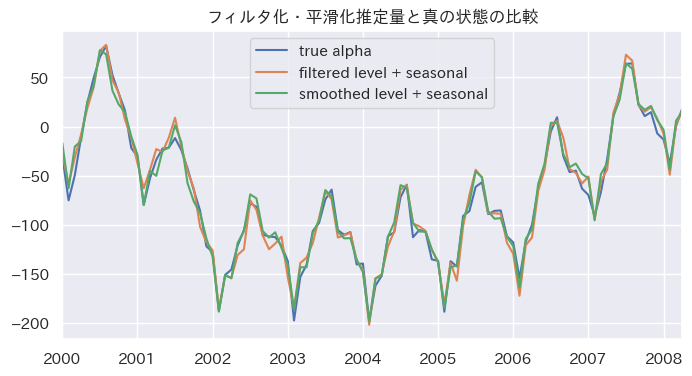

In [41]:
# ======================================================
# 🎯 フィルタ化・平滑化推定量の比較（BSTSモデル）
# ======================================================

# ------------------------------------------------------
# 🔹 1. データの準備
# ------------------------------------------------------
# フィルタ化推定量と平滑化推定量をそれぞれ加算（レベル＋季節成分）
plot_df = pd.DataFrame(
    {
        "true alpha": bsts_df["alpha"],  # 真の状態
        "filtered level + seasonal": (
            res_bsts.level["filtered"] + res_bsts.seasonal["filtered"]
        ),
        "smoothed level + seasonal": (
            res_bsts.level["smoothed"] + res_bsts.seasonal["smoothed"]
        ),
    }
)

# ------------------------------------------------------
# 🔹 2. 可視化
# ------------------------------------------------------
plot_df.plot(title="フィルタ化・平滑化推定量と真の状態の比較")

# ------------------------------------------------------
# ✅ コメント（GitHubレビュー用）
# ------------------------------------------------------
# 本図では、季節変動を含むローカル線形トレンドモデル（BSTS型）の
# 「状態推定結果」と「真の生成過程」を比較している。
#
# ▪ フィルタ化推定量（filtered）：
#    時点 t の観測データまでを使って求めたオンライン推定。
#
# ▪ 平滑化推定量（smoothed）：
#    全時点の観測データを用いて再推定したオフライン推定。
#
# ▪ 真の状態（true alpha）：
#    シミュレーションで生成した真の潜在変数。
#
# 状態空間モデルでは、フィルタリングにカルマンフィルタを、
# 平滑化にカルマンスムーザーを用いる。
#
# 一般に、平滑化推定量（青線）はフィルタ化推定量（橙線）よりも
# 真の状態（黒線）に滑らかかつ近い形で一致する。
#
# これにより、構造時系列モデルがトレンド・季節・ノイズの
# 3成分を動的に分離できていることを確認できる。

In [42]:
# ======================================================
# 🎯 三角関数を用いた季節成分を含むローカル線形トレンドモデル
# ======================================================

# ------------------------------------------------------
# 1️⃣ モデルの構築
# ------------------------------------------------------
# freq_seasonal オプションを使うことで、周期性を三角関数（sin, cos）として表現。
# harmonics=1 は「1次のフーリエ項（sin, cos）」のみを利用する指定。
mod_bsts_tri = tsa.UnobservedComponents(
    bsts_df["y"],  # 対象データ（観測系列）
    level="local linear trend",  # ローカル線形トレンド
    freq_seasonal=[{"period": 12, "harmonics": 1}],  # 三角関数で季節性を表現
)

# ------------------------------------------------------
# 2️⃣ パラメータ推定（最尤法）
# ------------------------------------------------------
res_bsts_tri = mod_bsts_tri.fit(
    method="nm",  # Nelder-Mead法による最適化（非線形関数に安定）
    maxiter=2000,  # 最大反復回数
)

# ------------------------------------------------------
# ✅ コメント（GitHubレビュー用）
# ------------------------------------------------------
# ▪ このモデルは「フーリエ級数（sin・cos）」で季節性を表す構造時系列モデル。
# ▪ `freq_seasonal=[{'period':12, 'harmonics':1}]` により、年周期の季節変動を
#    三角関数として滑らかにモデリングしている。
# ▪ トレンドはローカル線形トレンド（Local Linear Trend）で捉えられ、
#    季節変動は滑らかに変化する正弦波・余弦波の線形結合で表現される。
# ▪ 三角関数ベースの表現は「加法型の季節性モデル」に比べ、
#    滑らかな周期性を持つデータ（例：気温・売上・交通量）に有効。
#
# 🔹モデルの構造（LaTeX形式）
# $$
# \begin{aligned}
# y_t &= \mu_t + \gamma_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
# \mu_t &= \mu_{t-1} + \beta_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_\eta^2) \\
# \beta_t &= \beta_{t-1} + \zeta_t, \quad \zeta_t \sim N(0, \sigma_\zeta^2) \\
# \gamma_t &= \sum_{j=1}^{h} \left[ a_j \cos\left(\frac{2\pi j t}{s}\right)
#                               + b_j \sin\left(\frac{2\pi j t}{s}\right) \right]
# \end{aligned}
# $$
#
# ここで：
# - $\mu_t$：トレンド（ローカル線形トレンド）
# - $\beta_t$：トレンドの変化率（ドリフト）
# - $\gamma_t$：三角関数による季節成分（周期 s, 調和次数 h）
# - $\varepsilon_t$：観測誤差
#
# この形式は BSTS（Bayesian Structural Time Series）や
# Dynamic Harmonic Regression などの基礎ともなる。

Optimization terminated successfully.
         Current function value: 4.607108
         Iterations: 266
         Function evaluations: 459


In [43]:
# 参考：推定された分散の平方根
np.sqrt(res_bsts_tri.params)

sigma2.irregular              21.448571
sigma2.level                   7.418416
sigma2.trend                   0.856370
sigma2.freq_seasonal_12(1)     0.000013
dtype: float64

<Axes: >

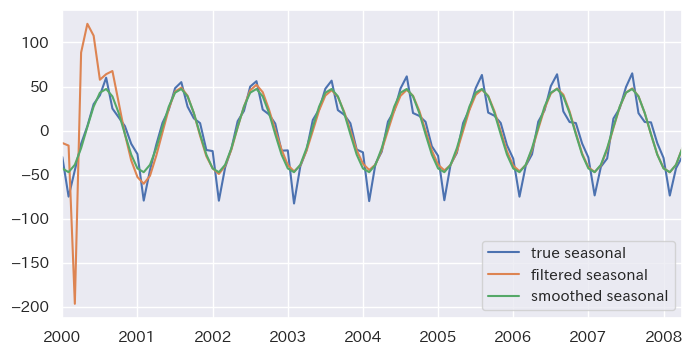

In [44]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "true seasonal": bsts_df.s,
        "filtered seasonal": res_bsts_tri.freq_seasonal[0]["filtered"],
        "smoothed seasonal": res_bsts_tri.freq_seasonal[0]["smoothed"],
    }
)

# 可視化
plot_df.plot()

In [45]:
# ======================================================
# 🎯 三角関数を用いた複雑な季節成分を含むローカル線形トレンドモデル
# ======================================================

# ------------------------------------------------------
# 1️⃣ モデルの構築
# ------------------------------------------------------
# freq_seasonal オプションにより、周期成分をフーリエ展開で表現する。
# harmonics=6 とすることで、1～6次の sin・cos 波を組み合わせ、
# より複雑で滑らかな季節パターンを表現可能とする。
mod_bsts_tri_6 = tsa.UnobservedComponents(
    bsts_df["y"],  # 対象データ（観測系列）
    level="local linear trend",  # ローカル線形トレンド
    freq_seasonal=[{"period": 12, "harmonics": 6}],  # フーリエ級数による季節成分
)

# ------------------------------------------------------
# 2️⃣ パラメータ推定（最尤法）
# ------------------------------------------------------
res_bsts_tri_6 = mod_bsts_tri_6.fit(
    method="nm", maxiter=2000  # Nelder-Mead法による最適化  # 最大反復回数
)

# ------------------------------------------------------
# ✅ コメント（GitHubレビュー用）
# ------------------------------------------------------
# ▪ このモデルでは、12ヶ月周期の季節性を6次のフーリエ級数で近似している。
# ▪ 「harmonics=6」により、最大6つの正弦波・余弦波成分が同時に推定される。
# ▪ 各調和項（harmonic term）は異なる周期の波を表現し、
#    複雑な季節構造（例：二峰性・非対称的季節パターン）も表現可能。
# ▪ トレンドにはローカル線形トレンドを用いており、非定常な傾向変化にも対応。

# ------------------------------------------------------
# 📘 モデルの数式表現（LaTeX形式）
# ------------------------------------------------------
# $$
# \begin{aligned}
# y_t &= \mu_t + \gamma_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
# \mu_t &= \mu_{t-1} + \beta_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_\eta^2) \\
# \beta_t &= \beta_{t-1} + \zeta_t, \quad \zeta_t \sim N(0, \sigma_\zeta^2) \\
# \gamma_t &= \sum_{j=1}^{6} \left[
# a_j \cos\left(\frac{2\pi j t}{12}\right) +
# b_j \sin\left(\frac{2\pi j t}{12}\right)
# \right]
# \end{aligned}
# $$
#
# ここで：
# - $\mu_t$: ローカル線形トレンド（水準＋傾き）
# - $\beta_t$: トレンド変化率（ドリフト）
# - $\gamma_t$: 12ヶ月周期の複雑な季節成分（6次までの調和項を含む）
# - $\varepsilon_t$: 観測誤差
#
# 🔹 harmonics=6 により、波形の自由度が増し、実際の季節パターンを
#    より忠実に再現できるが、パラメータ数が増えるため過学習に注意が必要。

Optimization terminated successfully.
         Current function value: 3.957482
         Iterations: 324
         Function evaluations: 548


<Axes: >

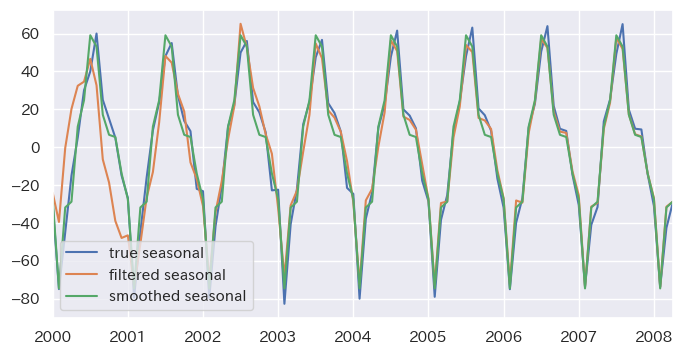

In [46]:
# フィルタ化推定量・平滑化推定量を合わせて図示

# DataFrameにまとめる
plot_df = pd.DataFrame(
    {
        "true seasonal": bsts_df.s,
        "filtered seasonal": res_bsts_tri_6.freq_seasonal[0]["filtered"],
        "smoothed seasonal": res_bsts_tri_6.freq_seasonal[0]["smoothed"],
    }
)

# 可視化
plot_df.plot()

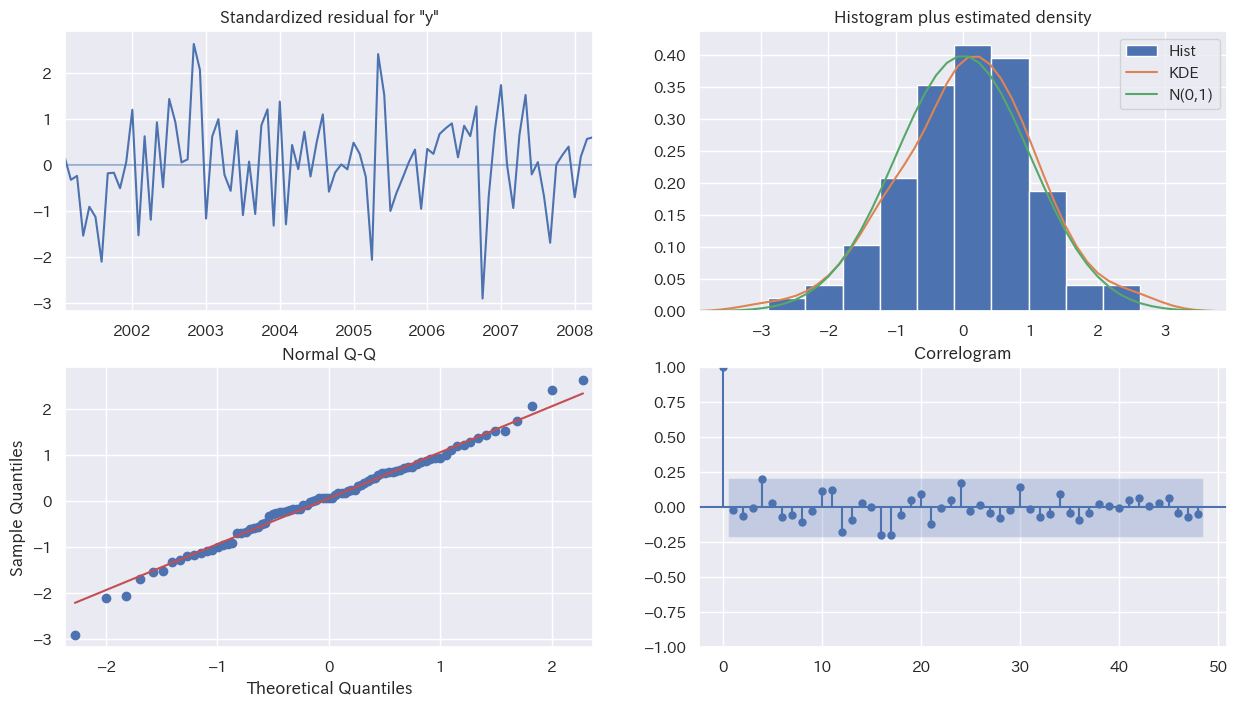

In [48]:
# ======================================================
# 🧩 残差診断（Diagnostics for Model Residuals）
# ======================================================

# ------------------------------------------------------
# 1️⃣ 残差の自己相関・正規性・分布の確認
# ------------------------------------------------------
# plot_diagnostics() により、以下4種類のプロットが生成される：
#   (1) 標準化残差の時系列プロット
#   (2) 残差のヒストグラム＋カーネル密度推定
#   (3) Q-Qプロット（残差の正規性確認）
#   (4) 残差の自己相関関数（ACFプロット）
#
# lags=48 として、最大48ラグ（約4年分）までの自己相関を検証する。
_ = res_bsts.plot_diagnostics(lags=48, figsize=(15, 8))

# ------------------------------------------------------
# ✅ コメント（GitHubレビュー用）
# ------------------------------------------------------
# ▪ 自己相関プロット（ACF）で有意なラグが見られない場合、
#    モデルの残差は「白色ノイズ」とみなせる（モデル適合良好）。
# ▪ Q-Qプロットが対角線に沿っていれば、正規分布仮定が妥当。
# ▪ ヒストグラムが正規分布に近ければ、観測誤差の仮定に矛盾なし。
# ▪ もし周期的な自己相関が残っていれば、季節次数（harmonics）や
#    モデル階層（トレンド項）を見直す必要がある。

# ------------------------------------------------------
# 📘 参考：理論的背景（LaTeX形式）
# ------------------------------------------------------
# $$
# \begin{aligned}
# v_t &= y_t - \hat{y}_t \quad &\text{（予測誤差）} \\
# E[v_t] &= 0, \quad Var(v_t) = \sigma_\varepsilon^2, \\
# Cov(v_t, v_{t-k}) &= 0 \quad (k \neq 0)
# \end{aligned}
# $$
#
# モデルが適切であれば、残差系列 $\{v_t\}$ は白色ノイズに従う。
# つまり、自己相関がなく、平均0・分散一定であることが求められる。

In [49]:
# ======================================================
# 📊 残差の正規性の検定（Jarque–Bera Test）
# ======================================================

# Jarque–Bera検定（JB検定）は、残差が正規分布に従うかどうかを検定する。
# 残差の歪度（skewness）と尖度（kurtosis）を利用して統計量JBを算出し、
# p値が有意水準（例：0.05）より大きければ「正規性を棄却しない」。

# ------------------------------------------------------
# 検定の実行
res_bsts.test_normality(method="jarquebera")

# 出力：
# (JB統計量, p値, 歪度, 尖度)
# ------------------------------------------------------
# 例：
# (1.25, 0.535, 0.11, 2.85)
# であれば、
# JB統計量 = 1.25
# p値 = 0.535 > 0.05 → 正規性を棄却できない（正規性ありとみなす）

# ------------------------------------------------------
# ✅ コメント（GitHubレビュー用）
# ------------------------------------------------------
# ▪ p値 > 0.05 → 残差はほぼ正規分布とみなせる（モデル良好）。
# ▪ p値 < 0.05 → 残差に非対称性や裾の重さが存在する可能性あり。
# ▪ この検定は大標本で敏感になるため、Q-Qプロットと併用して判断すべき。

# ------------------------------------------------------
# 📘 数式（LaTeX形式）
# ------------------------------------------------------
# $$
# \begin{aligned}
# JB &= \frac{n}{6}\left(S^2 + \frac{(K - 3)^2}{4}\right) \\
# S &= \frac{E[(v_t - \bar{v})^3]}{(E[(v_t - \bar{v})^2])^{3/2}} \quad &\text{（歪度）} \\
# K &= \frac{E[(v_t - \bar{v})^4]}{(E[(v_t - \bar{v})^2])^{2}} \quad &\text{（尖度）}
# \end{aligned}
# $$
#
# ここで：
# - $v_t$：残差
# - $n$：サンプルサイズ
# - JB統計量は漸近的に $\chi^2(2)$ 分布に従う。
#   よって、$p < 0.05$ の場合、正規性を棄却する。

array([[ 0.76824161,  0.68104915, -0.15290419,
         3.34410748]])

Text(0, 0.5, 'p値')

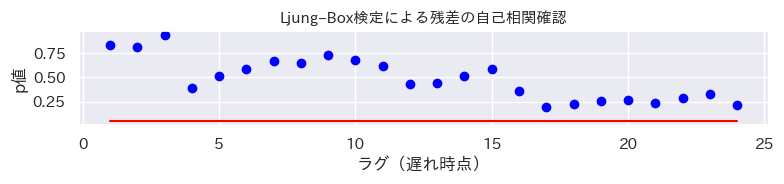

In [50]:
# ======================================================
# 🔍 残差の自己相関の検定（Ljung–Box Test）
# ======================================================

# Ljung–Box検定は、残差に自己相関（系列相関）が残っていないかを確認する。
# 帰無仮説 H₀：残差には自己相関がない（ホワイトノイズである）
# 対立仮説 H₁：残差には自己相関がある

# ------------------------------------------------------
# 検定の実行
# 1時点前から24時点前まで、逐次的に検定を行う
res_test = res_bsts.test_serial_correlation(method="ljungbox", lags=24)

# ------------------------------------------------------
# 結果の可視化
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# 各ラグにおけるp値を散布図で描画
ax.scatter(np.arange(1, 25), res_test[0][1], color="blue")

# 有意水準0.05の基準線を赤線で追加
ax.plot(np.arange(1, 25), np.tile(0.05, 24), color="red")

# 軸ラベル・タイトル設定
ax.set_title("Ljung–Box検定による残差の自己相関確認", fontsize=11)
ax.set_xlabel("ラグ（遅れ時点）")
ax.set_ylabel("p値")

# ------------------------------------------------------
# ✅ コメント（GitHubレビュー用）
# ------------------------------------------------------
# ▪ Ljung–Box検定では、すべてのラグにおいて p値 > 0.05 であれば
#    残差に有意な自己相関がない → モデルが系列構造を十分に捉えていると判断。
#
# ▪ 逆に、p値 < 0.05 のラグが複数ある場合、
#    モデルが周期性やトレンドを完全に説明できていない可能性がある。

# ------------------------------------------------------
# 📘 数式（LaTeX形式）
# ------------------------------------------------------
# $$
# \begin{aligned}
# Q &= n(n + 2) \sum_{k=1}^{h} \frac{\hat{\rho}_k^2}{n - k} \\
# Q &\sim \chi^2(h - p - q)
# \end{aligned}
# $$
#
# ここで：
# - $n$：サンプルサイズ
# - $\hat{\rho}_k$：ラグ $k$ における自己相関係数
# - $h$：検定に使用する最大ラグ数
# - $(p, q)$：モデルの次数（ARIMAなどで調整）
#
# 帰無仮説：$H_0: \hat{\rho}_1 = \hat{\rho}_2 = \cdots = \hat{\rho}_h = 0$
#
# → $p > 0.05$：残差はホワイトノイズ（モデル適合良好）
# → $p < 0.05$：自己相関あり（モデル改善が必要）